In [1]:
pip install -r libr.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model

In [3]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [4]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 793 files belonging to 2 classes.


In [5]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [6]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 101 files belonging to 2 classes.


In [7]:
testing_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [9]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 250, 250, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,541,134 (85.99 MB)

 Trainable params: 22,541,128 (85.99 MB)

 Non-trainable params: 6 (24.00 B)

In [12]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(training_data, validation_data=validation_data, epochs=20, callbacks=callbacks_list)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8901 - loss: 0.2583
Epoch 1: val_accuracy improved from -inf to 0.77551, saving model to model_weights.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8914 - loss: 0.2556 - val_accuracy: 0.7755 - val_loss: 0.6048 - learning_rate: 0.0010
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9348 - loss: 0.1802
Epoch 2: val_accuracy improved from 0.77551 to 0.81633, saving model to model_weights.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.9344 - loss: 0.1797 - val_accuracy: 0.8163 - val_loss: 0.4773 - learning_rate: 0.0010
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9345 - loss: 0.1394
Epoch 3: val_accuracy did not improve from 0.81633
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.9353 - loss: 0.1388 - val_accuracy: 0.7653 - val_loss: 0.8604 - learning_rate: 0.0010
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9465 - loss: 0.1289
Epoch 4: val_accuracy did not imp

In [17]:
###### serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

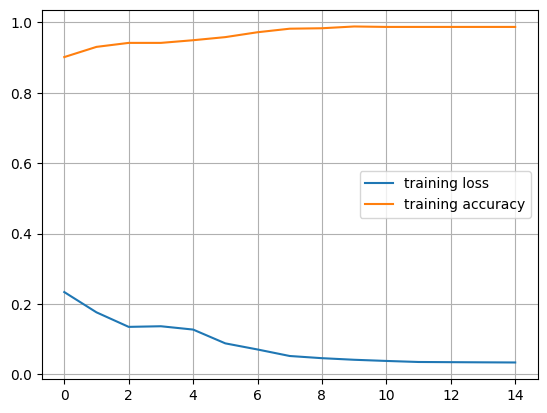

In [18]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

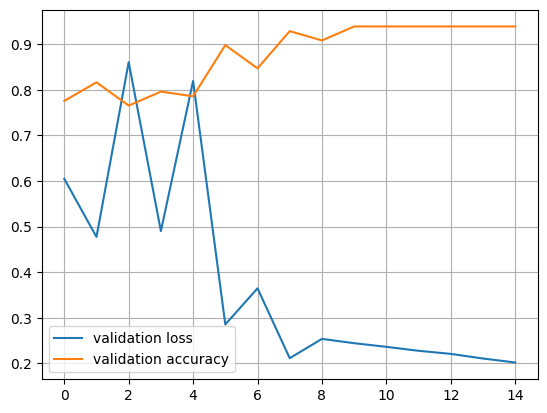

In [19]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


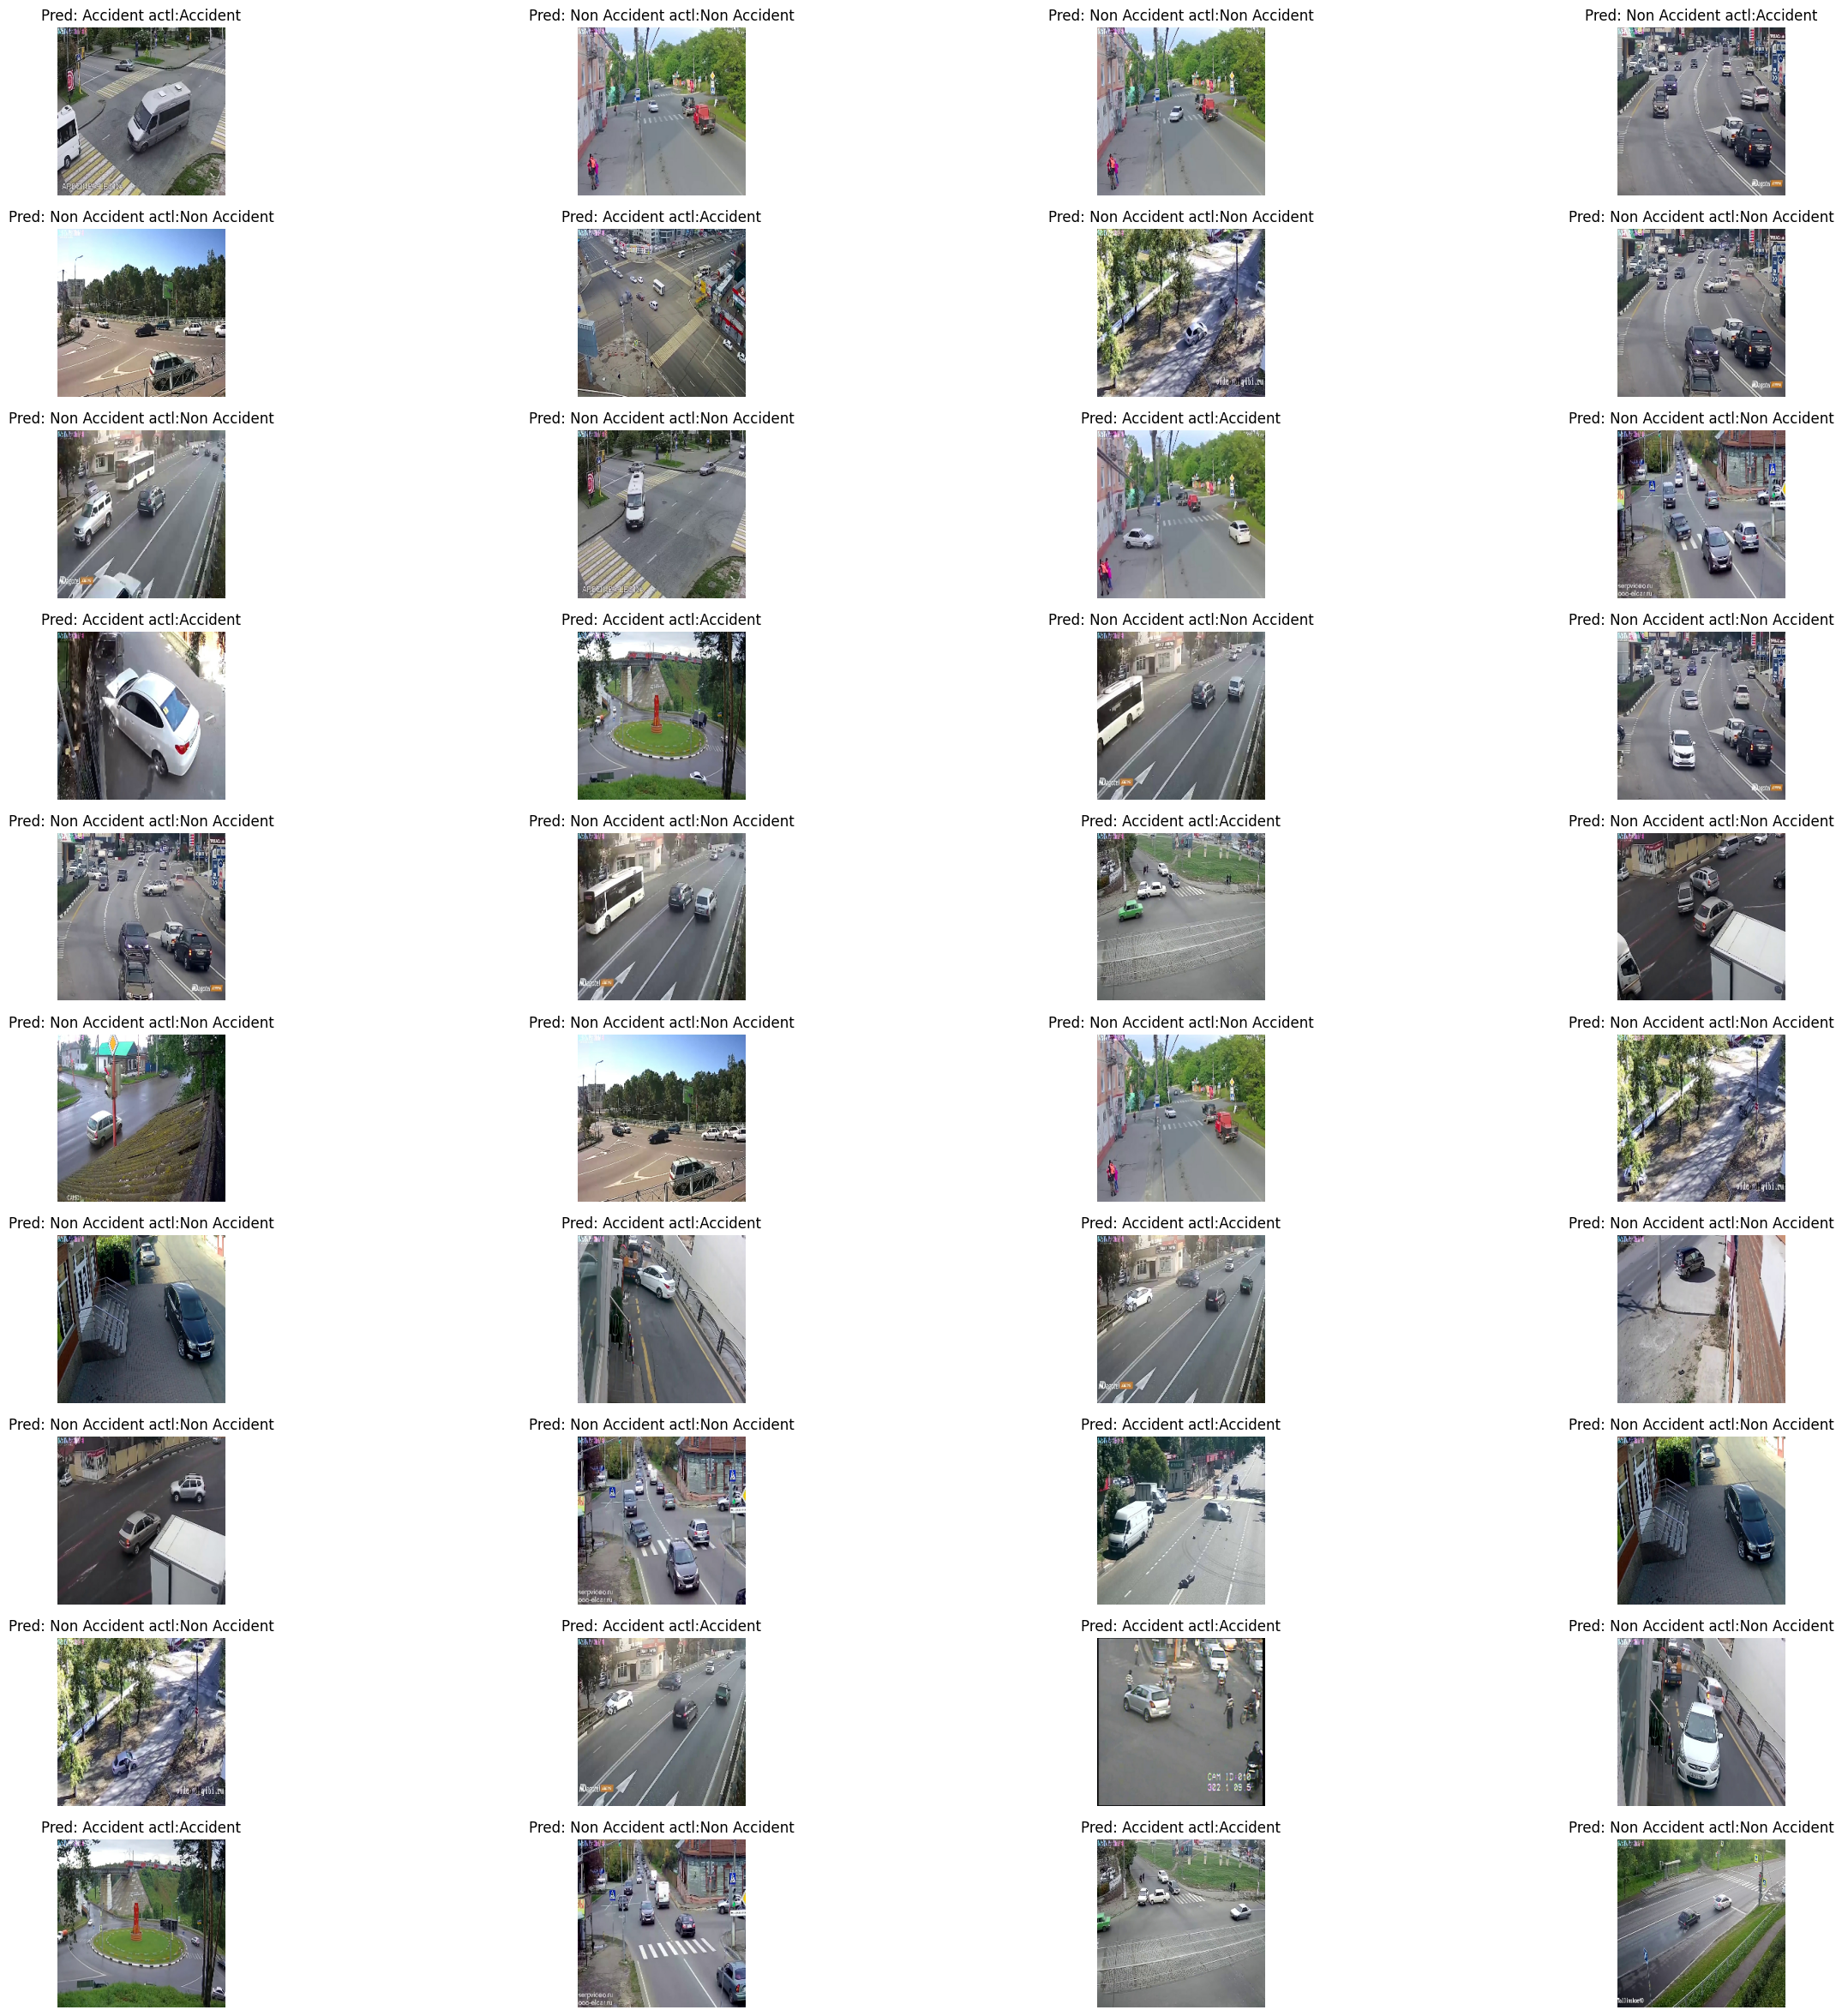

In [20]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)